In [3]:
!pip install -U scikit-learn

  Using cached scikit_learn-0.23.2-cp36-cp36m-macosx_10_9_x86_64.whl (7.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [65]:
# import libraries 

# utility/data wrangling
import pandas as pd
import numpy as np
from warnings import filterwarnings

# chart creations
import matplotlib.pyplot as plt
import seaborn as sns

# pre processing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks # down sampling
from imblearn.over_sampling import SMOTE # up sampling


# model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Model Validation 
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve

# statistical testing
from scipy.stats import f_oneway
from scipy import stats

# # py file
# import src

filterwarnings('ignore')
%matplotlib inline

In [100]:
RandomForestClassifier()

RandomForestClassifier()

In [ ]:
# Class imbalance

In [114]:
# import data set and drop id:
df = pd.read_csv('./data/training_cleaning.csv')
df.drop(columns=['id'], inplace=True)

In [137]:
pay = [
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
]

bills = [
    'bill_amt1',
    'bill_amt2',
    'bill_amt3',
    'bill_amt4',
    'bill_amt5',
    'bill_amt6'
]

payments = [
     'pay_amt1',
     'pay_amt2',
     'pay_amt3',
     'pay_amt4',
     'pay_amt5',
     'pay_amt6',
]
all_0 = df[payments].sum(axis=1) == 0
(df[payments].gt(0, axis='rows').sum(axis=1) == 0).value_counts()



False    21435
True      1064
dtype: int64

In [122]:
df[all_0][bills+payments+['default']].groupby(['default']).bill_amt1.count()

default
0    669
1    395
Name: bill_amt1, dtype: int64

# Observe class imbalance in the data set

In [11]:
print(17471/5028)
df.groupby(['default']).male.count()

3.4747414478918057


default
0    17471
1     5028
Name: male, dtype: int64

There are 17471 non defaulting participants and 5028 defaulting participants which means 3.5 non-defaults to 1. I will use 'balanced', 'smote' and tomeks links.

# pipeline so far

changed this up heavily
1) categorize education 1-4, drop highschool 

2) categorize marriage, married, not married, not married

3) Make a credit utility columns based on account_balance = df1.limit_bal - df1[bills].sum(axis=1) + df1[payments].sum(axis=1)

- Side thought. Those people who had net negative bill or account balance, had a 1/2 the chance of defaulting though there were not that many of them.
    - I think that is worth catting them into their own thing. 

4) categorze limit_bal into 4 bins based on IQR, drop 'low'\

5) categorize age based on iqr, drop young


6) Summed the pay columns to create a new column called delinquency that will be interacted with all the other columns.

In order to be sure about our method, we will first do a train test split of the data

In [29]:
# split the data

X = df.drop(columns=['default'])
y = df.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16874, 23), (5625, 23), (16874,), (5625,))

# Test out the baseline model

In [30]:
logReg = LogisticRegression(class_weight = 'balanced')

logReg.fit(X_train, y_train)
y_hat = logReg.predict(X_test)
f1_score(y_test, y_hat)
arr = cross_val_score(logReg,X_train, y_train, cv=10, scoring='f1', verbose = 1, n_jobs=-1)
baseline_CV = np.mean(arr)    
print(f"the baseline cross validation is {baseline_CV}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


the baseline cross validation is 0.41528002226364535


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


So with no modifications to the data set, there was a cross validation score on the logistic regression of 

# Categorize and dummy education

Education is clearly a categorical variable

In [25]:
# create education categorised and then drop the column
def education_categories(n):
    if n > 3 or n == 0:
        return 'other'
    elif n == 3:
        return 'high_school'
    elif n == 2:
        return 'university'
    elif n == 1:
        return 'post_grad'

    
edu_cat = df.education.apply(education_categories)
edu_cat_dummies = pd.get_dummies(edu_cat, drop_first=True)
edu_cat_dummies
df_1 = df.drop(columns = 'education')
df_1 =pd.concat([df_1, edu_cat_dummies], axis=1)

In [26]:
df_1

,limit_bal,male,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,other,post_grad,university
0,220000,0,2,36,0,0,0,0,0,0,...,10000,8018,10121,6006,10987,143779,1,0,1,0
1,200000,0,2,29,-1,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,0,0,0,0
2,180000,0,2,27,-2,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,1,0
3,80000,1,2,32,0,0,0,0,0,0,...,1853,1700,1522,1548,1488,1500,0,0,0,1
4,10000,1,2,27,0,0,0,0,0,0,...,2000,1100,600,300,300,1000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,40000,0,1,38,0,0,3,2,2,2,...,4600,1200,1400,0,3069,0,1,0,0,1
22495,350000,1,1,42,-1,-1,-1,-1,-1,-1,...,3138,4160,3750,2272,8210,9731,0,0,1,0
22496,100000,0,2,46,1,-1,2,2,-1,0,...,203,0,0,7856,10000,865,0,0,0,0
22497,20000,0,1,50,-1,-1,-1,-1,-2,-2,...,3754,6906,290,0,0,0,1,0,0,0


In [42]:
# split the data

X = df_1.drop(columns=['default'])
y = df_1.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
logReg_1 = LogisticRegression(class_weight = 'balanced')

logReg_1.fit(X_train, y_train)
y_hat = logReg.predict(X_test)
f1_score(y_test, y_hat)
arr = cross_val_score(logReg,X_train, y_train, cv=10, scoring='f1', verbose = 1, n_jobs=-1)
edu_dummy_f1 = np.mean(arr)     
print(f"the baseline cross validation is {edu_dummy_f1}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


the baseline cross validation is 0.41333154467819444


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


So dummying educatiuon did not seem to make a large difference to the f1 score. But what happens if we also add in dummies for marriage too.

# Marriage dummies + edu dummies

In [39]:
# Categorize married/not married
def marriage_categorization(n):
    if n == 1:
        return 'married'
    else: 
        return 'not_married'

mar_cat = df_1.marriage.apply(marriage_categorization)
mar_cat_dummies = pd.get_dummies(mar_cat)
df_2= df_1.drop(columns=['marriage'])
df_2 = pd.concat([df_2, mar_cat_dummies], axis=1)
df_2.drop(columns=['not_married'], inplace=True)
df_2.head()

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,other,post_grad,university,married
0,220000,0,36,0,0,0,0,0,0,222598,...,8018,10121,6006,10987,143779,1,0,1,0,0
1,200000,0,29,-1,-1,-1,-1,-1,-1,326,...,326,326,326,326,326,0,0,0,0,0
2,180000,0,27,-2,-2,-2,-2,-2,-2,0,...,0,0,0,0,0,0,0,1,0,0
3,80000,1,32,0,0,0,0,0,0,51372,...,1700,1522,1548,1488,1500,0,0,0,1,0
4,10000,1,27,0,0,0,0,0,0,8257,...,1100,600,300,300,1000,1,0,0,1,0


In [49]:
X = df_2.drop(columns=['default'])
y = df_2.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
logReg_2 = LogisticRegression(class_weight = 'balanced')

logReg_2.fit(X_train, y_train)
y_hat = logReg.predict(X_test)
f1_score(y_test, y_hat)
arr = cross_val_score(logReg,X_train, y_train, cv=10, scoring='f1', verbose = 1, n_jobs=-1)
edu_mar_cat_f1 = np.mean(arr)      
print(f"the baseline cross validation is {edu_mar_cat_f1}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


the baseline cross validation is 0.41426044023482367


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


Including the dummy columns for marriage status and education have lowered my score a little bit from baseline. But I stand by my decision to use categorical data for those features. 

# Adding in a delinquency column by summing up pay_0 -- pay_6

In [59]:
pay = [
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
]

delinquency = df[pay].sum(axis=1)
df_3 = df_2.copy()
df_3['delinquency'] = delinquency
df_3_smoll = df_3.drop(columns=pay)
df_3

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,other,post_grad,university,married,delinquency
0,220000,0,36,0,0,0,0,0,0,222598,...,10121,6006,10987,143779,1,0,1,0,0,0
1,200000,0,29,-1,-1,-1,-1,-1,-1,326,...,326,326,326,326,0,0,0,0,0,-6
2,180000,0,27,-2,-2,-2,-2,-2,-2,0,...,0,0,0,0,0,0,1,0,0,-12
3,80000,1,32,0,0,0,0,0,0,51372,...,1522,1548,1488,1500,0,0,0,1,0,0
4,10000,1,27,0,0,0,0,0,0,8257,...,600,300,300,1000,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,40000,0,38,0,0,3,2,2,2,35183,...,1400,0,3069,0,1,0,0,1,1,9
22495,350000,1,42,-1,-1,-1,-1,-1,-1,3800,...,3750,2272,8210,9731,0,0,1,0,1,-6
22496,100000,0,46,1,-1,2,2,-1,0,0,...,0,7856,10000,865,0,0,0,0,0,3
22497,20000,0,50,-1,-1,-1,-1,-2,-2,5141,...,290,0,0,0,1,0,0,0,1,-8


In [60]:
X = df_3.drop(columns=['default'])
y = df_3.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

logReg_3 = LogisticRegression(class_weight = 'balanced')

logReg_3.fit(X_train, y_train)
y_hat = logReg_3.predict(X_test)
f1_score(y_test, y_hat)
arr = cross_val_score(logReg,X_train, y_train, cv=10, scoring='f1', verbose = 1, n_jobs=-1)
df_3_f1 = np.mean(arr)      
print(f"the delinquency cross validation is {df_3_f1}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


the baseline cross validation is 0.41669525468321195


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


Delinquency increased the overall score slightly, I will now see if removingthe individual payment columns helps or hurts the model

In [63]:
X = df_3_smoll.drop(columns=['default'])
y = df_3.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

logReg_3_smoll = LogisticRegression(class_weight = 'balanced')

logReg_3_smoll.fit(X_train, y_train)
y_hat = logReg_3_smoll.predict(X_test)
f1_score(y_test, y_hat)
arr = cross_val_score(logReg,X_train, y_train, cv=10, scoring='f1', verbose = 1, n_jobs=-1)
df_3_f1_smoll = np.mean(arr)      
print(f"the baseline cross validation is {df_3_f1_smoll}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


the baseline cross validation is 0.41847708809195333


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


Another Fractional improvement. Let's remove outliers from the df_3_smoll deliquency feature

# Removing outliers from the delinquency

In [ ]:
# perform a test train split
X = df_3_smoll.drop(columns=['default'])
y = df_3.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [75]:
# instantiate a scalar
scalar = StandardScaler()
scaled_delinquency_train = scalar.fit_transform(X_train[['delinquency']])
X_train['deli'] = scaled_delinquency_train 
X_test['deli'] =  scalar.transform(X_test[['delinquency']])

X_train.deli.describe()

count    1.687400e+04
mean    -2.442306e-17
std      1.000030e+00
min     -1.846575e+00
25%     -6.610903e-01
50%      1.856842e-01
75%      1.856842e-01
max      6.282460e+00
Name: deli, dtype: float64

In [91]:
def scaled_outliers(n):
    if n > 3:
        return np.nan
    else:
        return n

X_train.deli.apply(scaled_outliers)

9737    -1.846575
6325     2.387298
3410     0.524394
2227     0.016329
6715     0.185684
           ...   
11964    2.217943
21575   -0.322380
5390     1.540523
860      0.524394
15795   -1.846575
Name: deli, Length: 16874, dtype: float64

In [99]:
pd.concat([X_train, y_train],axis=1)[(X_train.deli > 2) | (X_train.deli < -3)].groupby(['default']).male.count()

default
0    259
1    570
Name: male, dtype: int64

In [69]:
X_2.columns.to_list()

['limit_bal',
 'male',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'other',
 'post_grad',
 'university',
 'married']

In [104]:
# Create a credit utility category
pay = [
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
]

bills = [
    'bill_amt1',
    'bill_amt2',
    'bill_amt3',
    'bill_amt4',
    'bill_amt5',
    'bill_amt6'
]

payments = [
     'pay_amt1',
     'pay_amt2',
     'pay_amt3',
     'pay_amt4',
     'pay_amt5',
     'pay_amt6',
]

# account balance
account_balance = X_2[bills].sum(axis=1) - X_2[payments].sum(axis=1)
X_2['bill'] = X_2[bills].sum(axis=1)
X_2['payments'] = X_2[payments].sum(axis=1)
X_2['account_balance'] = account_balance
# credit utility
X_2['credit_utility'] = account_balance / X_2.limit_bal
X_2

# Delinquency  

delinquency = X_2[pay].sum(axis=1)
X_2['delinquency'] = delinquency
print(X_2.shape)
sns.scatterplot(x=X_2[X_2.delinquency > 10].delinquency, y=y_train);

NameError: name 'X_2' is not defined

In [71]:
df_train[X_2.delinquency > 30].groupby(['default']).delinquency.count()

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


default
0    11
1    17
Name: delinquency, dtype: int64

In [72]:
stats.ttest_ind(df_train[df_train.default == 1].delinquency, df_train[df_train.default == 0].delinquency, equal_var=False)





Ttest_indResult(statistic=31.028320325098402, pvalue=8.167999333854941e-193)

In [73]:
df_train[df_train.default == 1].delinquency.mean()- df_train[df_train.default == 0].delinquency.mean()

3.9916028114659534

# Test out X_2 with and without the extra categoris

we have dummies for education marriage and we have added te bill, pay and delincquency

In [75]:

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X_2,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16874, 30), (5625, 30), (16874,), (5625,))

In [101]:
X = X_2.drop(columns= bills)#+bills+payments)

X_trainM, X_testM, y_trainM, y_testM = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_trainM.shape, X_testM.shape, y_trainM.shape, y_testM.shape

((16874, 24), (5625, 24), (16874,), (5625,))

In [102]:
X_trainM.head()

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt1,...,pay_amt6,other,post_grad,university,married,bill,payments,account_balance,credit_utility,delinquency
9737,110000,0,25,-2,-2,-2,-2,-2,-2,165,...,0,0,0,1,0,15877,53282,-37405,-0.340045,-12
6325,30000,0,43,2,2,2,2,3,2,500,...,1400,0,0,0,0,87732,5200,82532,2.751067,13
3410,180000,0,28,0,0,0,0,0,2,2500,...,2000,0,0,1,0,226042,10128,215914,1.199522,2
2227,50000,0,33,0,0,0,0,-1,0,5000,...,1000,0,0,1,1,150206,35168,115038,2.300760,-1
6715,50000,1,47,0,0,0,0,0,0,3956,...,1000,0,0,1,0,257359,9169,248190,4.963800,0


In [106]:
logReg = LogisticRegression(class_weight = 'balanced')

logReg.fit(X_trainM, y_trainM)
y_hat = logReg.predict(X_testM)
f1_score(y_testM, y_hat)
arr = cross_val_score(logReg,X_trainM, y_trainM, cv=10, scoring='accuracy')
np.mean(arr)                      

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/

0.6463173321586676

In [81]:
# Linear regression
logReg = LogisticRegression(class_weight = 'balanced')

logReg.fit(X_train, y_train)
y_hat = logReg.predict(X_test)
f1_score(y_test, y_hat)
cross_val_score(logReg,X_train, y_train, cv=5, scoring='f1')

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/

array([0.47792998, 0.45399908, 0.46646341, 0.44604317, 0.44390244])

In [80]:
forest = RandomForestClassifier(class_weight='balanced')
cross_val_score(forest,X_train, y_train, cv=5, scoring='f1')

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

array([0.41813136, 0.41909814, 0.39530686, 0.40353982, 0.38286235])

In [57]:
# Let's have a look at those with the highest credit 
df_train = pd.concat([X_2, y_train], axis=1)#.sort_values('credit_utility', ascending=False).iloc[:100].groupby(['default']).credit_utility.count()

In [42]:
print(df_train[df_train.bill <= 0].groupby(['default']).bill.count()[1]/df_train[df_train.bill <= 0].groupby(['default']).bill.count()[0])

df_train.groupby(['default']).bill.count()[1]/df_train.groupby(['default']).bill.count()[0]

0.4748201438848921


0.2862260843052062

In [47]:
print(df_train[df_train.account_balance <= 0].groupby(['default']).bill.count()[1]/df_train[df_train.account_balance <= 0].groupby(['default']).bill.count()[0])

df_train.groupby(['default']).bill.count()[1]/df_train.groupby(['default']).bill.count()[0]

0.23767026773132927


0.2862260843052062

In [29]:
test_df = pd.concat([X_2, y_train], axis=1)#.sort_values('account_balance', ascending=True)

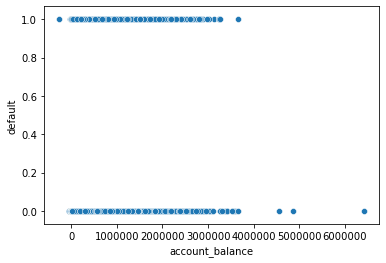

In [23]:
sns.scatterplot(x=X_2.account_balance, y=y_train);

In [31]:
test_df[(test_df.bill < 0) & (test_df.default == 1)].iloc[:5]

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,other,post_grad,university,married,credit_utility,account_balance,bill,default
1767,200000,1,34,1,-2,-1,0,0,-2,-1730,...,0,0,0,1,0,0,-0.010280,-2056,-5056,1
11552,340000,1,43,1,-2,-2,-2,-2,-2,-15,...,0,0,0,0,1,1,-0.000265,-90,-90,1
21267,30000,0,24,-1,-1,-1,-1,2,2,165,...,0,5527,0,1,0,0,0.204300,6129,-51,1
5605,360000,0,32,1,-2,-2,-2,-2,-2,-301,...,0,0,0,0,1,1,-0.005017,-1806,-1806,1
12113,140000,0,54,1,-2,-2,-2,-2,-2,-150,...,0,0,0,0,0,1,-0.006429,-900,-900,1


# A side thought

There are individuals where their total bills over the period were net negative. This indicates that they were given credit by the credit card companies or that they over paid. Let's look at the pay column and see if there are any patterns amongst the individuals who were paid money

In [63]:
bills_df = test_df[bills]
negative_bills = bills_df[bills_df < 0].replace(np.nan, 0)
sum_negative_bills = negative_bills.sum(axis=1)
test_df = pd.concat([test_df, sum_negative_bills], axis = 1)


In [69]:
test1_df=pd.concat([test_df, y_train], axis=1)
test1_df[(test1_df[0] != 0)]# & (test1_df.default == 1)]

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,other,post_grad,university,married,credit_utility,account_balance,0,default
9737,110000,0,25,-2,-2,-2,-2,-2,-2,-2628,...,5000,0,0,0,1,0,0.628718,69159,-15626.0,0
14148,260000,0,33,-2,-1,-1,-1,0,0,0,...,0,0,0,1,0,0,0.021531,5598,-810.0,0
16290,180000,0,47,1,-2,-1,-1,-2,-1,-6,...,679,421,0,1,0,0,0.023750,4275,-12.0,0
17664,50000,0,24,1,-2,-1,0,0,0,-1037,...,1100,1250,0,0,0,1,4.312300,215615,-2074.0,0
11943,180000,1,49,-1,-1,2,2,-2,-2,1092,...,0,0,0,1,0,1,0.025894,4661,-1302.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,150000,1,39,1,-2,-2,-1,-1,-2,-7,...,0,0,0,0,1,1,0.110373,16556,-7.0,0
2612,150000,0,49,1,-2,-1,-1,0,-1,-260,...,2868,4384,1,0,0,0,0.280707,42106,-3095.0,0
14502,230000,0,34,-2,-2,-2,-2,-2,-2,1716,...,0,0,0,0,1,0,-0.014530,-3342,-10003.0,0
3005,20000,1,25,1,-1,-1,0,0,0,-431,...,1000,4000,0,1,0,0,1.060800,21216,-431.0,0


In [37]:
# Categorize limit bal into 4 based on iqr
X_2.limit_bal.describe()

count      16874.000000
mean      166689.562641
std       129474.424792
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

In [41]:
def limit_bal_tocat(n):
    if n <= 50000:
        return 'low'
    elif  n <= 140000:
        return 'low_mid'
    elif n <= 240000:
        return 'high_mid'
    else:
        return 'high'
    
X_3 = X_2.copy()    
X_3['limit_cat'] = X_3.limit_bal.apply(limit_bal_tocat)
limit_cat_dummies = pd.get_dummies(X_3.limit_cat)
X_3 = pd.concat([X_3, limit_cat_dummies], axis=1)
X_3 = X_3.drop(columns=['limit_cat', 'limit_bal', 'low'])
X_3.head()

,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt4,pay_amt5,pay_amt6,other,post_grad,university,married,high,high_mid,low_mid
9737,0,25,-2,-2,-2,-2,-2,-2,-2628,-5118,...,10000,5000,0,0,0,1,0,0,0,1
6325,0,43,2,2,2,2,3,2,13509,13499,...,0,0,1400,0,0,0,0,0,0,0
3410,0,28,0,0,0,0,0,2,42238,38741,...,2500,0,2000,0,0,1,0,0,1,0
2227,0,33,0,0,0,0,-1,0,39554,38600,...,20130,1000,1000,0,0,1,1,0,0,0
6715,1,47,0,0,0,0,0,0,91481,47099,...,1000,1000,1000,0,0,1,0,0,0,0


In [60]:
# Categorize age based on iqr
X_3.age.describe()

def age_tocat(n):
    if n <= 28:
        return 'young'
    elif  n <= 34:
        return 'young_mid'
    elif n <= 41:
        return 'old_mid'
    else:
        return 'old'

X_4 = X_3.copy()
age_cat = X_4.age.apply(age_tocat)
age_cat_dummies = pd.get_dummies(age_cat)
X_4 = pd.concat([X_4, age_cat_dummies], axis=1)
X_4.drop(columns=['age', 'young'], inplace=True)

In [ ]:
# credit the credit utilization column
bills = [
    'bill_amt1',
    'bill_amt2',
    'bill_amt3',
    'bill_amt4',
    'bill_amt5',
    'bill_amt6'
]

payments = [
     'pay_amt1',
     'pay_amt2',
     'pay_amt3',
     'pay_amt4',
     'pay_amt5',
     'pay_amt6',
]

account_balance = X_4.limit_bal - df1[bills].sum(axis=1) + df1[payments].sum(axis=1)
df1['account_balance'] = account_balance

# credit utility
df1['credit_utility'] = df1['account_balance'] / df1.limit_bal *100

In [ ]:
# Run through 100 
c_values = list(np.linspace(0.01, 1, 100))
models = [LogisticRegression(penalty='l1', C=value, solver='saga') for value in c_values]

fit = [model.fit(X_train, y_train) for model in models]

predictions = [model.predict(X_test) for model in fit]

auc = [metrics.roc_auc_score(y_test, prediction) for prediction in predictions]

all_the_things = sorted(list(zip([x for x in c_values], auc)), key=lambda x: x[1], reverse=True)
all_the_things

# Grid search for a random forest on my data

In [10]:
decision_tree = DecisionTreeClassifier(random_state=1)

# creating our parameters to test
param_dict={
    'max_depth': range(1,10,1),
    'min_samples_leaf': range(1,6,1),
    'max_leaf_nodes': [None, 17,20,15],
    'min_samples_split': range(2,10, 1)
}


grid_tree=GridSearchCV(decision_tree,
                       param_grid = param_dict,
                       cv=10, 
                       scoring='f1',
                       verbose=1,
                       n_jobs=-1
                      )

grid_tree.fit(X_train,y_train);

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1545 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3545 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4845 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5870 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6720 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7670 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 8720 tasks      | elapsed:  7.6min
[P

KeyboardInterrupt: 

In [ ]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)